In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

#TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large

2025-04-24 18:30:43.050610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 18:30:43.050644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 18:30:43.051856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 18:30:43.058066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 18:30:43.644541: W tensorflow/compiler/tf2

In [2]:
# Load dataset
def load_dataset(dir_path):
    """
    Load dataset from a given directory path.
    
    Args:
        dir_path (str): Path to the dataset directory.
    
    Returns:
        tuple: A tuple containing:
            - training_dataset (np.array): Array of training data.
            - testing_dataset (np.array): Array of testing data.
            - label_train (pd.DataFrame): DataFrame of training labels.
            - label_test (pd.DataFrame): DataFrame of testing labels.
    """
    
    train_path = os.path.join(dir_path, 'Train')
    test_path = os.path.join(dir_path, 'Test')
    
    label_training = os.path.join(dir_path, 'label_train.csv')
    label_testing = os.path.join(dir_path, 'test_format.csv')
    
    training_files = os.listdir(train_path)
    testing_files = os.listdir(test_path)
    
    # Load training and testing datasets
    training_dataset = []
    for path in training_files:
        if path.endswith('.npy'):
            train_data = np.load(os.path.join(train_path, path))
            training_dataset.append(train_data)
            
    testing_dataset = []
    for path in testing_files:
        if path.endswith('.npy'):
            test_data = np.load(os.path.join(test_path, path))
            testing_dataset.append(test_data)
    
    # Load labels
    label_train = pd.read_csv(label_training)
    label_test = pd.read_csv(label_testing)
    
    
    return np.array(training_dataset), np.array(testing_dataset), label_train, label_test

After splitting training to testing:
Training:
Input (1773, 72, 48)
Labels: (1773, 3)
Testing:
Input: (120, 72, 48)
Labels: (120, 3)


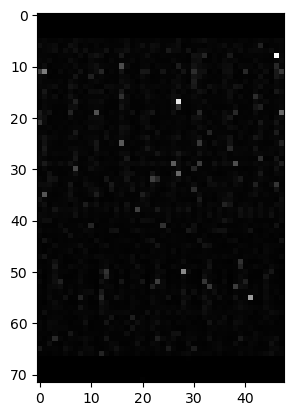

In [3]:
train, test, train_labels, test_labels = load_dataset('Dataset/')

# Convert all data from db to linear scale
train = 10 ** (train/20)
test = 10 ** (test/20)


# Shuffle frequency response order
non_zero_indexes = np.where(train_labels['target'] != 0)[0]
n_samples = train_labels.shape[0]
# Create a new array to hold the augmented data
augmented_data = np.zeros((len(non_zero_indexes), train.shape[1], train.shape[2]))
# Create a new array to hold the augmented labels
augmented_labels = np.zeros((len(non_zero_indexes), train_labels.shape[1]))
# Generate augmented data
used_indexes = []
for i, index in enumerate(non_zero_indexes):
    # Reshuffle frequency responses
    p = np.random.permutation(train[index].shape[1])
    augmented_data[i] = train[index][:, p]
    # Copy the corresponding label
    augmented_labels[i] = train_labels.iloc[index]
    augmented_labels[i][0] = int(n_samples + i)
   
# Add noise
n_samples = train_labels.shape[0] + augmented_data.shape[0]
for i, index in enumerate(non_zero_indexes):
    # Add Gaussian noise to the selected training data
    noise = np.random.normal(0, 0.0001, train[index].shape)
    augmented_data[i] = train[index]+ noise
    # Copy the corresponding label
    augmented_labels[i] = train_labels.iloc[index]
    augmented_labels[i][0] = int(n_samples + i)    

# Create a pandas dataframe with collumds
augmented_labels = pd.DataFrame(augmented_labels, columns=["ID", "target"])

# Append the augmented data and labels to the original training data and labels
train = np.concatenate((train, augmented_data))
train_labels = pd.concat([train_labels, pd.DataFrame(augmented_labels)], ignore_index=True, copy=False)


# testing_split = 0
# Take some samples from the training data and move them to testing
#test = np.concatenate((test, train[:testing_split]))
#test_labels = pd.concat([test_labels, train_labels[:testing_split]], ignore_index=True, copy=False)

# Remove the samples from the training data
#train = train[testing_split:]
#train_labels = train_labels[testing_split:]

# Remove the ID column
train_labels = train_labels.drop(columns=['ID'])

#Shuffle training dataset
#p = np.random.permutation(train_labels.index)
#train = train[p]
#train_labels = train_labels.iloc[p].reset_index(drop=True)

#Convert labels to int
train_labels['target'] = train_labels['target'].astype(int)
test_labels['target'] = test_labels['target'].astype(int)

#Remove some targets that have the label 0 from training data
# Number of target 0 samples to remove
# n = 1000

# # Get indices of rows with target 0
# target_0_indices = train_labels[train_labels['target'] == 0].index

# # Randomly sample n indices from target 0
# indices_to_remove = np.random.choice(target_0_indices, size=n, replace=False)

# # Create a mask for all indices except the ones to remove
# mask = ~train_labels.index.isin(indices_to_remove)

# # Update the training labels and dataset
# train_labels = train_labels[mask].reset_index(drop=True)
# train = train[mask]

all_classes = sorted(set(train_labels['target']).union(set(test_labels['target'])))
train_labels_coded = pd.get_dummies(train_labels['target']).reindex(columns=all_classes, fill_value=False)
test_labels_coded = pd.get_dummies(test_labels['target']).reindex(columns=all_classes, fill_value=False)

print('After splitting training to testing:')
print('Training:')
print('Input', train.shape)
print('Labels:', train_labels_coded.shape)
print('Testing:')
print('Input:', test.shape)
print('Labels:', test_labels_coded.shape)

plt.imshow(train[10], cmap='gray')
plt.show()

In [4]:
# Creating a model

#Convolutional Neural Network
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(72, 48, 1)),
    MaxPooling2D(),
    
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(3)
])

# Linear Neural Network
# model = Sequential([
#     InputLayer(input_shape=(72, 48, 1)),
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(16, activation='relu'),
#     Dense(8, activation='relu'),
#     Dropout(0.5),
#     Dense(len(all_classes), activation='softmax')
# ])

batch_size = 16
n_of_epochs = 100
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
optim = Adam(learning_rate=0.005)

model.compile(optimizer=optim, loss= 'CategoricalCrossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 35, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 4, 128)         0

2025-04-24 18:30:44.554140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-24 18:30:44.590580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-24 18:30:44.593135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
#Train the model
validation_split = 0.2

history = model.fit(train, train_labels_coded, 
                     batch_size=batch_size, 
                     epochs=n_of_epochs,
                     validation_split = validation_split,
                     callbacks=[lr_reducer, early_stopping],)

Epoch 1/100


2025-04-24 18:30:45.834228: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-04-24 18:30:47.690488: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f11998d7b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-24 18:30:47.690515: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-24 18:30:47.695992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745519447.773690  739038 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/89 [==============================] - 5s 11ms/step - loss: 5.1767 - accuracy: 0.2362 - val_loss: 7.2846 - val_accuracy: 0.4338 - lr: 0.0050
Epoch 2/100
89/89 [==============================] - 0s 5ms/step - loss: 2.6546 - accuracy: 0.5289 - val_loss: 2.8958 - val_accuracy: 0.1915 - lr: 0.0050
Epoch 3/100
89/89 [==============================] - 0s 5ms/step - loss: 2.7415 - accuracy: 0.4788 - val_loss: 1.8176 - val_accuracy: 0.1746 - lr: 0.0050
Epoch 4/100
89/89 [==============================] - 0s 5ms/step - loss: 1.6616 - accuracy: 0.4330 - val_loss: 2.0936 - val_accuracy: 0.1803 - lr: 0.0050
Epoch 5/100
89/89 [==============================] - 0s 5ms/step - loss: 1.2057 - accuracy: 0.6474 - val_loss: 6.9148 - val_accuracy: 0.2085 - lr: 0.0050
Epoch 6/100
89/89 [==============================] - 0s 5ms/step - loss: 1.5699 - accuracy: 0.7426 - val_loss: 6.2280 - val_accuracy: 0.2056 - lr: 0.0050
Epoch 7/100
89/89 [==============================] - 0s 5ms/step - loss: 2.0928 - accur

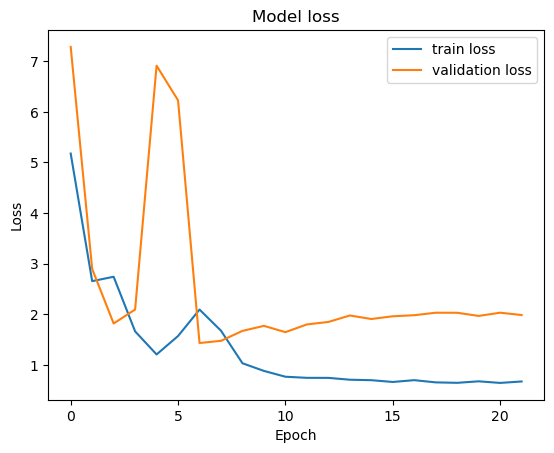

In [6]:
# Plot the training loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [7]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test, test_labels_coded)
results = model.predict(test)
#print('Mean square error:', test_mae)
print('Loss:', test_loss)
print('Accuracy: {:.2f}%'.format(test_acc * 100))

# Format results into same format as labels with one collumn
results = pd.DataFrame(results, columns=all_classes)
results['target'] = results.idxmax(axis=1)
results = results[['target']]
results = results.astype(int)
results = pd.concat([test_labels['ID'], results], axis=1)

# Save the results to a CSV file
results.to_csv('submission.csv', index=False)

# illegal = int(np.sum(test_labels>0))
# zeros = int(np.sum(test_labels==0))
# ratio = 100 - (illegal/(illegal+zeros)) * 100
# print("percantage differeence: ",ratio)

4/4 [==============================] - 0s 1ms/step
Loss: 0.5816348195075989
Accuracy: 97.50%
